# Corona in Hamburg

In [1]:
import datetime
import json
import os
import re
import urllib.parse

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
BOROUGHS = {
    "Altona": 275265,
    "Bergedorf": 130260,
    "Eimsbüttel": 267053,
    "Hamburg Mitte": 301546,
    "Hamburg Nord": 314595,
    "Harburg": 169426,
    "Wandsbek": 441015,
    "Hamburg": 1899160,
}

In [3]:
RESTRICTIONS = {
    datetime.date(2020, 2, 29): ("", "w"),
    datetime.date(2020, 3, 16): ("schools closed", "y"),
    datetime.date(2020, 3, 23): ("lockdown", "r"),
    datetime.date(2020, 4, 20): ("", "y"),
    datetime.date(2020, 4, 27): ("masks required", "g"),
    datetime.date(2020, 10, 12): ("masks required in more areas", "b"),
    datetime.date(2020, 10, 26): ("contact restrictions", "y"),
    datetime.date(2020, 11, 2): ("lockdown \"light\"", "m"),
    datetime.date(2020, 12, 16): ("lockdown", "r")
}

In [4]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    soup = bs4.BeautifulSoup(r.text)
    historic_case_data_header = soup.find("h2", text="Inzidenz zum Download")
    if historic_case_data_header:
        df = pd.read_excel(
            urllib.parse.urljoin(
                CORONA_DATA_URL,
                historic_case_data_header.parent.find_next("div").a["href"]
            ),
            index_col=1,
            skiprows=[0],
            parse_dates=True
        )
        daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
        df = df.drop(
            set(df.columns) - {"Datum", "Gesamthaft gemeldete SARS-CoV-2 Infektionen"},
            axis="columns"
        ).rename(columns={
            "Datum": "date",
            "Gesamthaft gemeldete SARS-CoV-2 Infektionen": "cases"
        })

        try:
            date = pd.DateOffset(days=-1).apply(df.index[0])
            df.loc[date] = daily_cases.cumsum().loc[date]
            df = df.dropna().sort_index().diff().dropna().astype(int)

            daily_cases.update(df)
            daily_cases.astype(int).to_csv("corona-hamburg-daily.csv")
        
        except Exception as e:
            pass

    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if not header:
        header = soup.find("h2", text="Neue Fälle: Sieben Tage Inzidenz")

    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Bei der Inzidenz"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r+") as f:
                lines = [line.strip() for line in f]
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())

        with open("corona-hamburg.csv", "r+") as f:
            lines = [line.strip() for line in f]
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2:
                f.write(f"{total_cases_line}\n")

In [5]:
r = requests.get("https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Hamburg")
if r.ok:
    soup = bs4.BeautifulSoup(r.text)
    data = json.loads(re.findall(r"RLCONF=(.*?);", soup.script.string, re.DOTALL)[0].replace("!0", "true").replace("!1", "false"))
    graph_id = soup.find_all(attrs={"class": "mw-graph"})[3]["data-graph-id"]
    df = pd.DataFrame([[datetime.datetime.strptime(e["x"], "%Y/%m/%d").date(), e["y"]] for e in data["wgGraphSpecs"][graph_id]["data"][0]["values"]], columns=["date", "deaths"]).set_index("date").astype(int)
    df.to_csv("corona-hamburg-deaths.csv")

In [6]:
daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()

In [7]:
total_cases = pd.read_csv("corona-hamburg.csv", index_col=0, parse_dates=True)
new_cases = total_cases.diff().dropna().astype(int)

In [8]:
total_deaths = pd.read_csv("corona-hamburg-deaths.csv", index_col=0, parse_dates=True)

In [9]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Total Cases

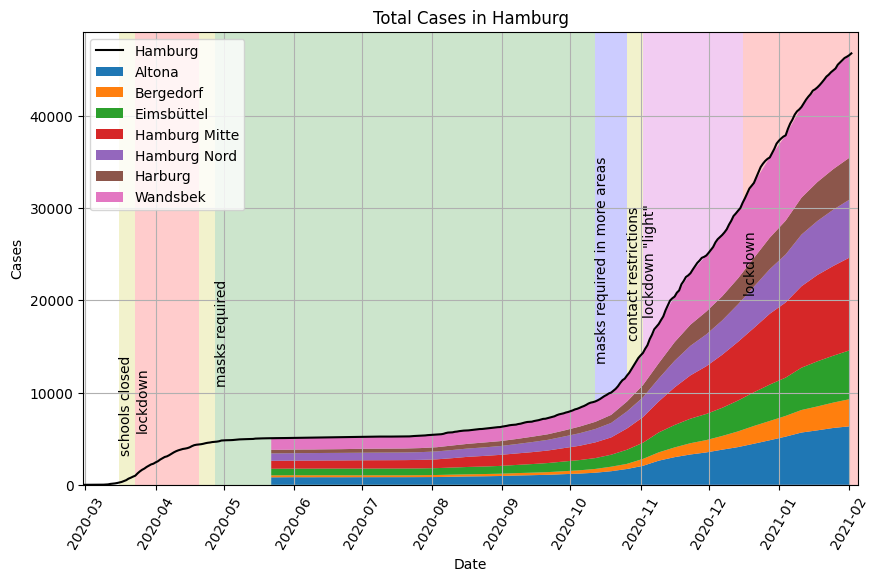

In [10]:
plt.figure()
plt.title("Total Cases in Hamburg")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(total_cases.index, *total_cases.values.T, labels=total_cases.columns)
plt.plot(daily_cases.index, daily_cases.cumsum().values, "black", label="Hamburg")
y = 1000
dy = 2500 # (daily_cases.cumsum().values.max() - 5000) / (len(RESTRICTIONS) - 1)
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
    plt.annotate(text, (date, y), rotation=90)
    y += dy
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

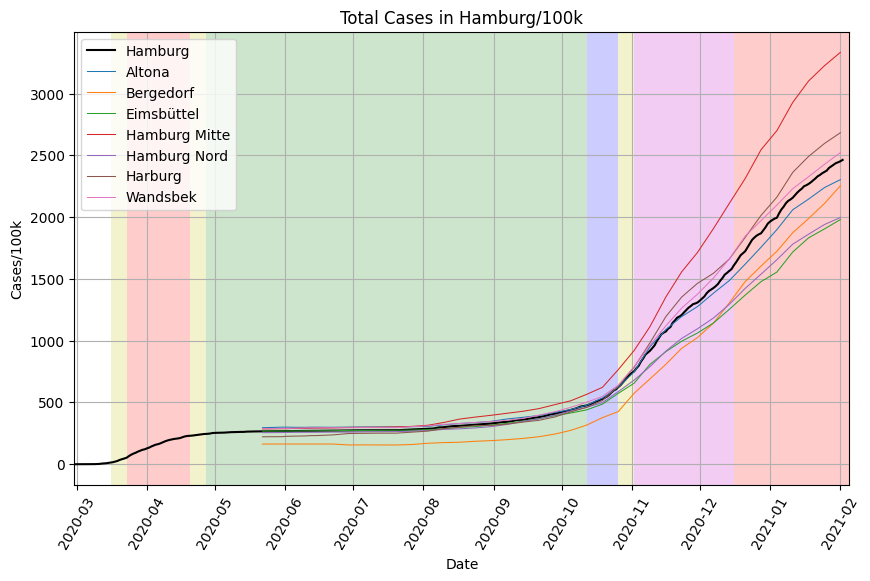

In [11]:
plt.figure()
plt.title("Total Cases in Hamburg/100k")
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.plot(daily_cases.index, daily_cases.cumsum().values / BOROUGHS["Hamburg"] * 1e5, "black", label="Hamburg")
for borough in new_cases.columns:
    plt.plot(total_cases.index, total_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

In [12]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-11-30,3513,1336,2837,5171,3450,2481,6072,24860
2020-12-07,3810,1487,3052,5750,3723,2618,6646,27086
2020-12-14,4091,1701,3347,6365,4070,2813,7328,29715
2020-12-21,4456,1925,3655,6971,4476,3109,8138,32730
2020-12-28,4834,2089,3946,7674,4839,3412,8695,35489
2021-01-04,5226,2245,4153,8141,5207,3662,9249,37883
2021-01-11,5669,2441,4587,8830,5603,4002,9834,40966
2021-01-18,5907,2590,4893,9353,5857,4221,10263,43084
2021-01-25,6163,2749,5085,9725,6103,4398,10703,44926


In [13]:
daily_cases.cumsum().tail(8).T

date,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02
cases,45132,45543,45789,46023,46272,46407,46562,46771


## New Cases

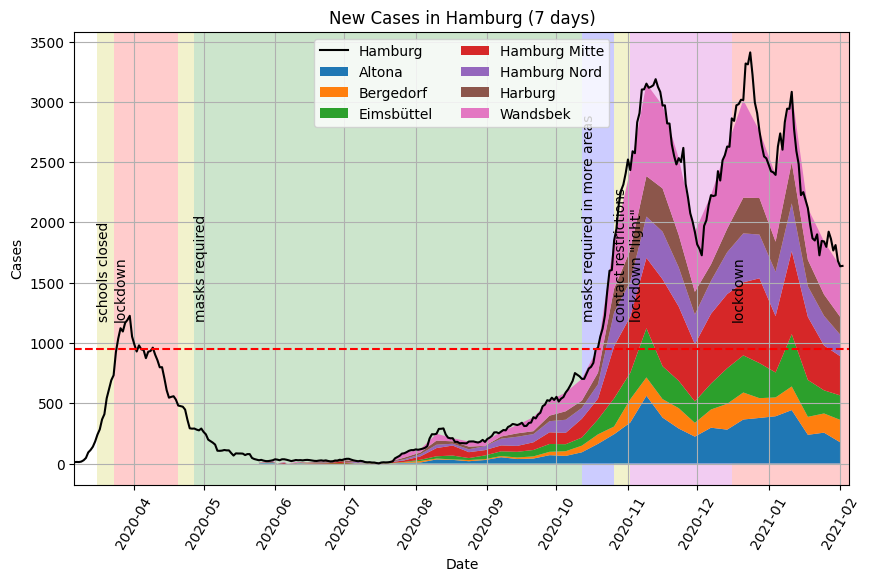

In [14]:
plt.figure()
plt.title("New Cases in Hamburg (7 days)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(new_cases.index, *new_cases.values.T, labels=new_cases.columns)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.axhline(y=950, c="r", ls="dashed")
xmax = daily_cases_rolling7.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
    plt.annotate(text, (date, 1200), rotation=90)
plt.legend(loc="upper center", ncol=2)
plt.xlim(xmin=daily_cases_rolling7.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

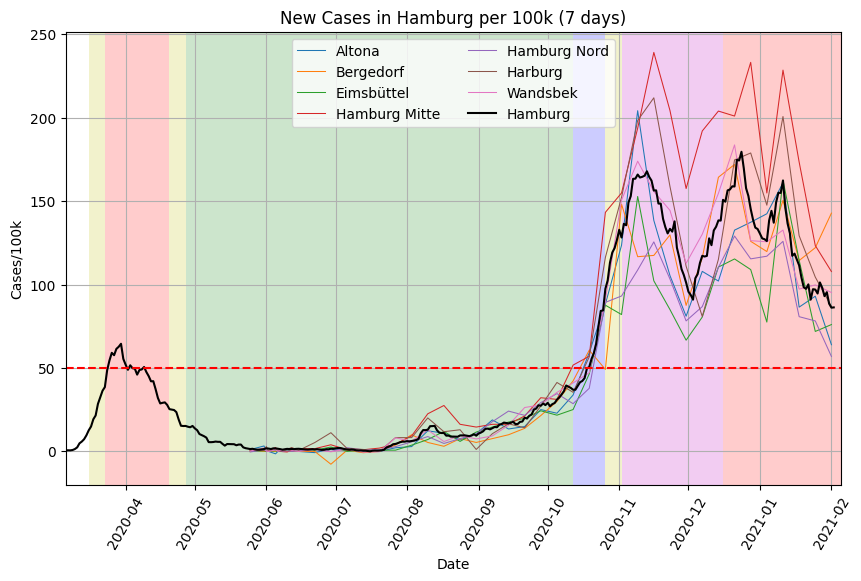

In [15]:
plt.figure()
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k-", label="Hamburg")
plt.axhline(y=50, c="r", ls="--")
xmax = daily_cases_rolling7.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper center", ncol=2)
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases_rolling7.index[0], xmax=xmax)
plt.grid()
plt.show()

In [16]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-11-30,223,114,178,475,246,188,497,1921
2020-12-07,297,151,215,579,273,137,574,2226
2020-12-14,281,214,295,615,347,195,682,2629
2020-12-21,365,224,308,606,406,296,810,3015
2020-12-28,378,164,291,703,363,303,557,2759
2021-01-04,392,156,207,467,368,250,554,2394
2021-01-11,443,196,434,689,396,340,585,3083
2021-01-18,238,149,306,523,254,219,429,2118
2021-01-25,256,159,192,372,246,177,440,1842


In [17]:
(new_cases / pd.DataFrame(BOROUGHS, index=new_cases.index) * 1e5).round(2).tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-11-30,81.01,87.52,66.65,157.52,78.20,110.96,112.69,101.15
2020-12-07,107.90,115.92,80.51,192.01,86.78,80.86,130.15,117.21
2020-12-14,102.08,164.29,110.46,203.95,110.30,115.09,154.64,138.43
2020-12-21,132.60,171.96,115.33,200.96,129.05,174.71,183.67,158.75
2020-12-28,137.32,125.90,108.97,233.13,115.39,178.84,126.30,145.27
2021-01-04,142.41,119.76,77.51,154.87,116.98,147.56,125.62,126.06
2021-01-11,160.94,150.47,162.51,228.49,125.88,200.68,132.65,162.33
2021-01-18,86.46,114.39,114.58,173.44,80.74,129.26,97.28,111.52
2021-01-25,93.00,122.06,71.90,123.36,78.20,104.47,99.77,96.99


In [18]:
daily_cases_rolling7.tail(8).T

date,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02
cases,1797.0,1923.0,1863.0,1767.0,1812.0,1682.0,1636.0,1639.0


In [19]:
df = (daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).round(2)
df["weekday"] = df.index.day_name()
df["week"] = df.index.week
df["year"] = [i.year - 1 if i.week == 53 and i.month == 1 else i.year for i in df.index]
df.pivot(index=("year", "week"), columns=["weekday"])["cases"][WEEKDAYS].loc[(2020, 42):]

weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
year week                                                                
2020 42     36.96    36.96      39.18     41.44   42.23     43.97   49.76
     43     50.60    55.45      58.92     64.61   75.14     84.20   84.51
     44     97.46   102.52     113.21    119.21  121.84    126.74  132.80
     45    128.16   136.38     135.53    149.07  153.02    163.34  163.44
     46    165.92   164.13     164.55    165.23  167.86    164.49  162.28
     47    156.33   156.44     148.54    148.49  139.38    134.38  130.64
     48    133.37   131.69     137.85    122.11  116.31    109.31  105.73
     49    101.15    95.73      93.78     90.93  103.78    106.26  112.94
     50    117.21   116.79     117.16    127.69  123.58    132.43  134.64
     51    138.43   138.32     150.75    149.65  156.44    156.96  158.86
     52    158.75   174.71     174.34    179.55  169.71    157.70  153.07
     53    145.27   138.96     134.11    133.27  130.53    127.64  127.16
2021 1     126.06   138.43     144.17    137.06  149.12    154.96  154.91
     2     162.33   146.17     136.53    130.79  117.21    118.53  115.10
     3     111.52   104.20      98.36     97.41  100.10     90.93   97.20
     4      96.99    94.62     101.26     98.10   93.04     95.41   88.57
     5      86.14    86.30        NaN       NaN     NaN       NaN     NaN

## Daily Cases

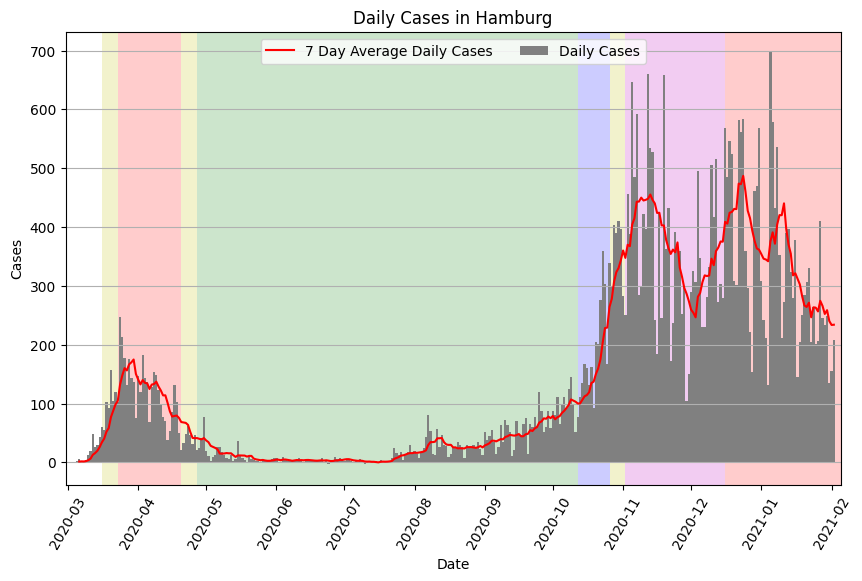

In [20]:
plt.figure()
plt.bar(daily_cases.index, daily_cases.values.T[0], width=1, color="grey", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "red", label="7 Day Average Daily Cases")
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.grid(axis="y")
plt.show()

In [21]:
df = daily_cases.copy()
df["weekday"] = df.index.day_name()
df["week"] = df.index.week
df["year"] = [i.year - 1 if i.week == 53 and i.month == 1 else i.year for i in df.index]
df = df.pivot(index=("year", "week"), columns=["weekday"])["cases"][WEEKDAYS]
df["mean"] = df.mean(axis=1).round(2)
df.loc[(2020, 42):]

weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
year week                                                                   
2020 42      77.0    112.0      135.0     168.0   160.0     131.0   162.0   
     43      93.0    204.0      201.0     276.0   360.0     303.0   168.0   
     44     339.0    300.0      404.0     390.0   410.0     396.0   283.0   
     45     251.0    456.0      388.0     647.0   485.0     592.0   285.0   
     46     298.0    422.0      396.0     660.0   535.0     528.0   243.0   
     47     185.0    424.0      246.0     659.0   362.0     433.0   172.0   
     48     237.0    392.0      363.0     360.0   252.0     300.0   104.0   
     49     150.0    289.0      326.0     306.0   496.0     347.0   231.0   
     50     231.0    281.0      333.0     506.0   418.0     515.0   273.0   
     51     303.0    279.0      569.0     485.0   547.0     525.0   309.0   
     52     301.0    582.0      562.0     584.0   360.0     297.0   221.0   
     53     153.0    462.0      470.0     568.0   308.0     242.0   212.0   
2021 1      132.0    697.0      579.0     433.0   537.0     353.0   211.0   
     2      273.0    390.0      396.0     324.0   279.0     378.0   146.0   
     3      205.0    251.0      285.0     306.0   330.0     204.0   265.0   
     4      201.0    206.0      411.0     246.0   234.0     249.0   135.0   
     5      155.0    209.0        NaN       NaN     NaN       NaN     NaN   

weekday      mean  
year week          
2020 42    135.00  
     43    229.29  
     44    360.29  
     45    443.43  
     46    440.29  
     47    354.43  
     48    286.86  
     49    306.43  
     50    365.29  
     51    431.00  
     52    415.29  
     53    345.00  
2021 1     420.29  
     2     312.29  
     3     263.71  
     4     240.29  
     5     182.00

In [22]:
(daily_cases_rolling7 / 7).tail(8).T.round(2)

date,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02
cases,256.71,274.71,266.14,252.43,258.86,240.29,233.71,234.14


## Deaths

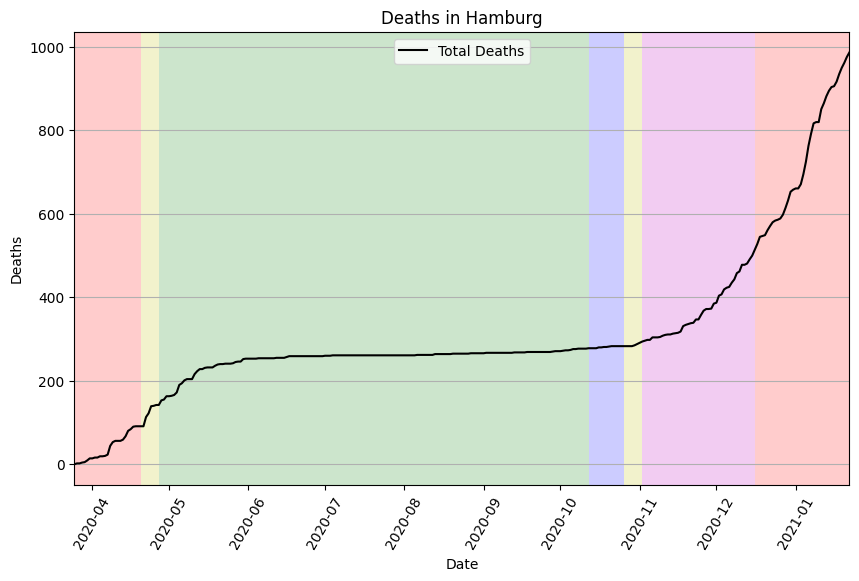

In [23]:
plt.figure()
plt.plot(total_deaths.index, total_deaths, "black", label="Total Deaths")
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else daily_cases_rolling7.index[-1], facecolor=color, alpha=0.2, zorder=-1)
plt.title("Deaths in Hamburg")
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.xticks(rotation=60)
plt.xlim(xmin=total_deaths.index[0], xmax=total_deaths.index[-1])
plt.grid(axis="y")
plt.show()

In [24]:
total_deaths.tail(8).T

date,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2021-01-19,2021-01-20,2021-01-21,2021-01-22
deaths,904,906,917,935,950,962,976,987
